In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# References

- [SKTBrain/KoBERT](https://github.com/SKTBrain/KoBERT)
- [eagle705/pytorch-bert-crf-ner](https://github.com/eagle705/pytorch-bert-crf-ner/blob/master/Visualization_BERT_NER.ipynb)
- [BERT to the rescue!](https://towardsdatascience.com/bert-to-the-rescue-17671379687f)
- [eagle705/pytorch-bert-crf-ner](https://github.com/eagle705/pytorch-bert-crf-ner/blob/master/data_utils/vocab_tokenizer.py)
- [pytorch-pretrained-bert](https://pypi.org/project/pytorch-pretrained-bert/#usage)

# Load pre-trained model

In [2]:
import io
import time

import pandas as pd
import numpy as np

import tqdm
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams['font.family'] = 'NanumGothic'

num_of_cores = 8

In [3]:
import torch
import torch.nn as nn
from kobert.pytorch_kobert import get_pytorch_kobert_model
from gluonnlp.data import SentencepieceTokenizer
from kobert.utils import get_tokenizer
from keras.preprocessing.sequence import pad_sequences
import sentencepiece as spm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_bert, vocab = get_pytorch_kobert_model()
del pretrained_bert

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

using cached model
using cached model


In [4]:
# Load pre-trained model tokenizer
tok_path = get_tokenizer()
print(tok_path)
sp = spm.SentencePieceProcessor()
print(sp)
sp.Load(tok_path)

using cached model
/root/kobert/tokenizer_78b3253a26.model
<sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7fb90c1297e0> >


True

In [5]:
# Tokenized input
text = ["누가 기침소리를 내었는가 ? 누구인가 ?"]
train_tokens = list(map(lambda t: ['[CLS]'] + sp.EncodeAsPieces(t) + ['[SEP]'], text))

print(text[0])
print(train_tokens[0])

train_tokens_ids = pad_sequences(list(map(vocab.to_indices, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
print(train_tokens_ids[0][:20])

누가 기침소리를 내었는가 ? 누구인가 ?
['[CLS]', '▁누가', '▁기', '침', '소리', '를', '▁내', '었', '는', '가', '▁?', '▁누구', '인', '가', '▁?', '[SEP]']
[   2 1527 1258 7491 6609 6116 1434 6885 5760 5330  633 1528 7119 5330
  633    3    0    0    0    0]


# Load Data

In [64]:
# Load and preprocess
def load_price(filename) : 
    price = pd.read_csv(filename, index_col=0)
    print(price.shape)
    '''
    # convert timestamp of price dataframe as datetime object
    pool = multiprocessing.pool.ThreadPool(num_of_cores)
    args = list(range(price.shape[0]))
    def price_to_datetime(i) : 
        price['time'].iloc[i] = pd.to_datetime(str(price['date'].iloc[i])+str(price['time'].iloc[i]), format='%Y%m%d%H%M')
        pbar.update(1)
        return
    with tqdm.tqdm(total=len(args)) as pbar:
        for i in range(len(args)):
            pool.apply_async(price_to_datetime, [args[i]])
        pool.close()
        pool.join()       
    '''
    # convert timestamp of price dataframe as datetime object
    with tqdm.tqdm(total=price.shape[0]) as pbar :
        for i in range(price.shape[0]) : 
            price['time'].iloc[i] = pd.to_datetime(str(price['date'].iloc[i])+str(price['time'].iloc[i]), format='%Y%m%d%H%M')
            pbar.update(1)   
    # sort in ascending order
    price = price.sort_values(by='time').reset_index(drop=True)
    price.index = price['time']
    price = price.drop(['date', 'time'], axis=1)
    return price

filename = 'data/example/price_005930.csv'
price = load_price(filename)
display(price)

  0%|          | 0/3429 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
  7%|▋         | 238/3429 [00:00<00:02, 1187.14it/s]

(3429, 7)


100%|██████████| 3429/3429 [00:03<00:00, 889.50it/s] 


,close,high,low,open,vol
time,,,,,
2019-10-31 09:01:00,50900,51100,50900,51000,580976
2019-10-31 09:02:00,51100,51100,50900,50900,46699
2019-10-31 09:03:00,51100,51100,51000,51100,13198
2019-10-31 09:04:00,51000,51100,51000,51100,37929
2019-10-31 09:05:00,51000,51100,50900,51000,83816
...,...,...,...,...,...
2019-11-12 15:17:00,52400,52500,52400,52500,12420
2019-11-12 15:18:00,52500,52500,52400,52400,20269
2019-11-12 15:19:00,52500,52500,52400,52500,18480


In [65]:
# Load and preprocess
def load_reply(filename) : 
    reply = pd.read_csv(filename, index_col=0).reset_index(drop=True)
    print(reply.shape)
    # wrong data in the dataframe
    #display(pd.DataFrame(reply.iloc[209]).T)
    #display(pd.DataFrame(reply.iloc[210]).T)
    '''
    # convert timestamp of reply dataframe as datetime object, drop wrong rows
    list_to_drop = []
    pool = multiprocessing.pool.ThreadPool(num_of_cores)
    args = list(range(reply.shape[0]))
    def reply_to_datetime(i) : 
        try : 
            reply['Date'].iloc[i] = pd.to_datetime(reply['Date'].iloc[i], format='%Y.%m.%d %H:%M')
            pbar.update(1)
        except Exception as e :
            list_to_drop.append(i)
            pbar.update(1)
        return
    with tqdm.tqdm(total=len(args)) as pbar:
        for i in range(len(args)):
            pool.apply_async(reply_to_datetime, [args[i]])
        pool.close()
        pool.join() 
    '''
    # convert timestamp of reply dataframe as datetime object, drop wrong rows
    list_to_drop = []
    with tqdm.tqdm(total=reply.shape[0]) as pbar : 
        for i in range(reply.shape[0]) : 
            try : 
                reply['Date'].iloc[i] = pd.to_datetime(reply['Date'].iloc[i], format='%Y.%m.%d %H:%M')
                pbar.update(1)
            except Exception as e :
                list_to_drop.append(i)
                pbar.update(1)
    reply = reply.drop(list_to_drop, axis=0)

    # sort in ascending order
    reply = reply.sort_values(by='Date').reset_index(drop=True)
    reply.index = reply['Date']
    reply = reply.drop(['Date'], axis=1)

    return reply

filename = 'data/example/reply_005930.csv'
reply = load_reply(filename)

  1%|          | 152/20129 [00:00<00:26, 753.98it/s]

(20129, 7)


100%|██████████| 20129/20129 [00:27<00:00, 720.71it/s]


# Merge Dataset

2019-10-31 09:01:00
2019-11-12 15:30:00


,close,high,low,open,vol,Views,Title,Content,Like,Unlike,Ip
key_0,,,,,,,,,,,
2019-10-31 09:01:00,50900.0,51100.0,50900.0,51000.0,580976.0,192.0,계엄령 문건 덮었다는 '윤석열 직인'···알고보니 자동 출력,\r\n이젠 호모쉐퀴들도 부역자 노릇을 하는구나\r\r\n \r\n군대도 안다녀온...,6.0,4.0,125.178.***.115
2019-10-31 09:01:00,50900.0,51100.0,50900.0,51000.0,580976.0,544.0,오늘 실적발표 일...,자료는 공개되었네요\r\r\n못보신 분들은 확인하세요\r\r\n \r\nhttps:...,0.0,0.0,112.216.***.242
2019-10-31 09:02:00,51100.0,51100.0,50900.0,50900.0,46699.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31 09:03:00,51100.0,51100.0,51000.0,51100.0,13198.0,135.0,지금은 `폴더블폰` 시대…화면 확장 한계 넘는다ㅋ,ㅋㅋ,0.0,0.0,223.62.***.176
2019-10-31 09:04:00,51000.0,51100.0,51000.0,51100.0,37929.0,148.0,"삼성, 새로운 폴더블폰 공개…'갤럭시 폴드는 시작일 뿐'ㅋ",ㅋㅋ,0.0,0.0,223.62.***.176
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-12 08:52:00,NaN,NaN,NaN,NaN,NaN,125.0,소통·공감 밝힌 文대통령… '반성'은 없었다,\r\n임기 후반 첫 수보회의 주재/ “국민들 확실한 변화 체감 때까지/ 일관성 ...,2.0,4.0,125.178.***.115
2019-11-12 08:56:00,NaN,NaN,NaN,NaN,NaN,203.0,3Q 영업익 7조7800억…전년比 55.74% 감소 ㅋㅋ,3Q 영업익 7조7800억…전년比 55.74% 감소 ㅋㅋ\r\r\n \r\n하한가 ...,2.0,0.0,119.64.***.165
2019-11-12 08:57:00,NaN,NaN,NaN,NaN,NaN,149.0,히틀러보다 더 나쁜놈..,https://www.youtube.com/watch?v=Am5iwgX1mJw,0.0,1.0,125.143.***.181


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


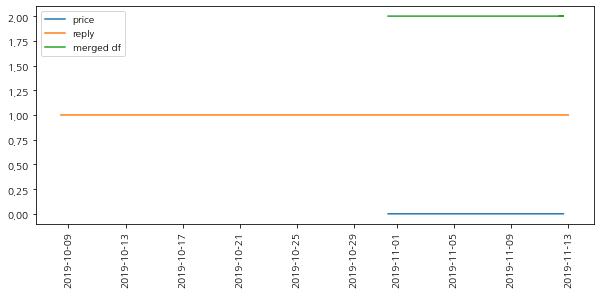

In [66]:
def merge_dataset(price, reply) : 
    # get intersection
    day_start = max(price.index[0], reply.index[0])
    day_end = min(price.index[-1], reply.index[-1])
    print(day_start)
    print(day_end)

    # merge dataframe
    reply_common = reply[(reply.index >= day_start) & (reply.index <= day_end)]
    price_common = price[(price.index >= day_start) & (price.index <= day_end)]
    #df = reply_common.merge(price_common, how='outer', left_on=reply_common.index, right_on=price_common.index)
    df = price_common.merge(reply_common, how='outer', left_on=price_common.index, right_on=reply_common.index)
    df.index = df['key_0']
    df = df.drop(['key_0'], axis=1)
    display(df)

    # check intersection of timestamp
    plt.figure(figsize=(10, 4))
    plt.plot(price.index, np.zeros(price.shape[0]), label='price')
    plt.plot(reply.index, np.ones(reply.shape[0]), label='reply')
    plt.plot(df.index, np.full(df.shape[0], 2), label='merged df')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

    return df

df = merge_dataset(price, reply)

# Preprocess Functions

### 부탁드릴 내용
- 제목 미리보기?
    - '오늘 실적발표 일...'
    - 페이지에 들어가서 잘리지 않은 제목으로

In [88]:
from urlextract import URLExtract
import re

In [89]:
df[0:1]

,key_0,close,high,low,open,vol,Views,Title,Content,Like,Unlike,Ip,PriceInTxt,target
0,2019-10-31 09:01:00,50900,51100,50900,51000,580976,192,계엄령 문건 덮었다는 '윤석열 직인'···알고보니 자동 출력,이젠 호모쉐퀴들도 부역자 노릇을 하는구나 군대도 안다녀온 게이새끼 허위사실유포로 ...,6,4,125.178.***.115,-1,51000


In [90]:
def replace_tag(content) : 
    return content.replace('\r', '').replace('\n', '').replace('\\', '')

In [91]:
def replace_link(content): 
    extractor = URLExtract()
    urls = extractor.find_urls(content)
    for url in urls : 
        content = content.replace(url, '링크')

    return content

In [92]:
def replace_punctuation(content) : 
    return content.replace(',', '')

In [93]:
def get_numbers(content) : 
    content = content.replace('만원', '0000')
    return content, [int(x) for x in re.findall('\d+', content)]

In [94]:
band = 0.1
# price in txt가 close와 얼마나 비슷한지 확인하고, 너무 차이나면 관계없는 숫자이기때문에 걸러야 함
# price in txt의 dimension도 확인하고, 너무 많을 경우 의미없는 숫자들일 가능성이 큼
def get_price_in_txt(numbers_in_txt, close) : 
    if len(numbers_in_txt) == 1 :
        number_in_txt = numbers_in_txt[0]
        if (number_in_txt <= close * (1+band)) and (number_in_txt >= close * (1-band)) :
            return number_in_txt
        else : 
            return -1
    else :
        return -1

In [95]:
def preprocess_pipeline(text, close) : 
    bypass = replace_tag(text)
    bypass = replace_link(bypass)
    bypass = replace_punctuation(bypass)
    bypass, numbers_in_txt = get_numbers(bypass)
    price_in_txt = get_price_in_txt(numbers_in_txt, close)
    
    return bypass, price_in_txt

### Examples

In [96]:
idx = 10
close = df['close'][idx]
text = df['Title'][idx]
bypass, price_in_txt = preprocess_pipeline(text, close)
print(bypass)
print(close, price_in_txt)

# Tokenized input
bypass = [bypass]
train_tokens = list(map(lambda t: ['[CLS]'] + sp.EncodeAsPieces(t) + ['[SEP]'], bypass))
print(train_tokens[0])
train_tokens_ids = pad_sequences(list(map(vocab.to_indices, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
print(train_tokens_ids[0][:20])

"내년 주시할 50대 기업에 한국에선 삼성전자만 포함"ㅋ
51200 -1
['[CLS]', '▁"', '내', '년', '▁주', '시', '할', '▁50', '대', '▁기업', '에', '▁한국', '에선', '▁삼성전자', '만', '▁포함', '"', 'ᄏ', '[SEP]']
[   2  518 5678 5712 4213 6705 7836  612 5808 1292 6896 4958 6906 2653
 6150 4864    8  492    3    0]


In [97]:
idx = 31
close = df['close'][idx]
text = df['Content'][idx]
bypass, price_in_txt = preprocess_pipeline(text, close)
print(bypass)
print(close, price_in_txt)

# Tokenized input
bypass = [bypass]
train_tokens = list(map(lambda t: ['[CLS]'] + sp.EncodeAsPieces(t) + ['[SEP]'], bypass))
print(train_tokens[0])
train_tokens_ids = pad_sequences(list(map(vocab.to_indices, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
print(train_tokens_ids[0][:20])

 종합편성채널 MBN이 2011년 개국 이래 최대 위기를 맞았다. 금융당국이 MBN 법인과 전 대표이사 등 3명을 검찰에 고발하면서 MBN의 종합편성(종편)채널 유지 여부가 불투명해졌다. 금융위원회 산하 증권선물위원회(증선위)는 지난 30일 정례회의를 열고 MBN의 외부감사법 위반 혐의에 대한 금융감독원의 감리 결과 조치안을 안건으로 상정해 의결했다. 증선위는 MBN 법인 장대환 전 대표이사 등 3명을 검찰에 고발하기로 결정했다. 현재 미등기임원으로 돼 있는 장 전 대표이사에 대한 해임권고도 의결했다. MBN에 과징금 70000000 감사인지정 3년의 조치도 내렸다. MBN은 2011년 종편 출범 당시 최소 자본금(3000억원)을 마련하기 위해 은행에서 임직원 명의로 550억원을 차명으로 대출받아 회사 주식을 사게 한 뒤 이를 은폐하기 위해 분식회계 했다는 의혹을 받고 있다. 증선위는 "MBN이 2011년 4월 유상증자를 통해 외부자금을 조달하는 과정에서 회사자금으로 자사주를 취득하고도 증자에 들어간 자금을 가공의 자산인 정기예금으로 허위 계상해 자기자본을 과대계상했다"고 설명했다. 회사가 회사 자금으로 자사주를 사고도 이를 은폐하기 위해 재무제표를 허위로 작성하는 등 고의 분식회계가 있었다는 판단이다. 증선위는 MBN 외부감사인인 위드회계법인에 대해 감사 절차 소홀로 손해배상 공동기금 추가적립 100%와 MBN에 대한 감사업무제한 5년 제재도 결정했다. 공인회계사 2명에 대한 검찰 고발과 MBN 감사업무 제한 5년 등도 의결했다. 종편 재승인 업무를 맡고 있는 방송통신위원회도 관련 조사를 벌이고 있다. 증선위의 이같은 제재가 향후 MBN의 종편 재승인 심사에 영향을 줄 수 있을 것이란 전망도 조심스레 나온다. MBN은 이번 사안과 관련해 사실무근이라는 입장을 밝혀왔다. 한경닷컴 뉴스룸 open@hankyung.com  
51200 -1
['[CLS]', '▁종합', '편', '성', '채널', '▁', 'MBN', '이', '▁2011', '년', '▁', 

# Apply Preprocessing Functions

In [98]:
def preprocess_content(idx) : 
    close = df['close'][idx]
    title = df['Title'][idx]
    content = df['Content'][idx]
    
    bypass_title, price_in_title = preprocess_pipeline(title, close)
    bypass_content, price_in_content = preprocess_pipeline(content, close)
    
    df['Title'].iloc[idx] = bypass_title
    df['Content'].iloc[idx] = bypass_content
    
    if df['PriceInTxt'].iloc[idx] == -1 : 
        df['PriceInTxt'].iloc[idx] = price_in_title
    if df['PriceInTxt'].iloc[idx] == -1 : 
        df['PriceInTxt'].iloc[idx] = price_in_content
    pbar.update(1)
    return

df['PriceInTxt'] = -1
preprocess_content(0)
display(df[0:1])

NameError: name 'pbar' is not defined

In [ ]:
# convert timestamp of price dataframe as datetime object
pool = multiprocessing.pool.ThreadPool(num_of_cores)
args = list(range(df.shape[0]))
df['PriceInTxt'] = -1

with tqdm.tqdm(total=len(args)) as pbar:
    for i in range(len(args)):
        pool.apply_async(preprocess_content, [args[i]])
    pool.close()
    pool.join()       
    
df.to_pickle('data/example/preprocessed_005930.pkl')

# Handle Numeric Values

In [ ]:
df

In [ ]:
columns = df.select_dtypes('float64').columns
for column in columns : 
    df[column] = df[column].astype('Int64')

df.to_pickle('data/example/preprocessed_005930.pkl')
df.info()

# EDA

In [ ]:
df = pd.read_pickle('data/example/preprocessed_005930.pkl')

In [68]:
# check text nan
# False : Text exists, True : NaN
textnan = df['Title'].isna()
textnan

key_0
2019-10-31 09:01:00    False
2019-10-31 09:01:00    False
2019-10-31 09:02:00     True
2019-10-31 09:03:00    False
2019-10-31 09:04:00    False
                       ...  
2019-11-12 08:52:00    False
2019-11-12 08:56:00    False
2019-11-12 08:57:00    False
2019-11-12 08:57:00    False
2019-11-12 08:59:00    False
Name: Title, Length: 8150, dtype: bool

In [69]:
# 1 : Text exists, 0 : NaN
print(textnan.value_counts())
textnan = textnan.apply(lambda x : 0 if x else 1) 
print(textnan.value_counts())

False    6033
True     2117
Name: Title, dtype: int64
1    6033
0    2117
Name: Title, dtype: int64


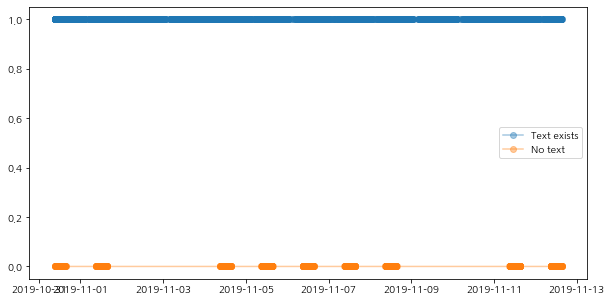

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(textnan[textnan==1], marker='o', label='Text exists', alpha=0.4)
plt.plot(textnan[textnan==0], marker='o', label='No text', alpha=0.4)
plt.legend()
plt.show()

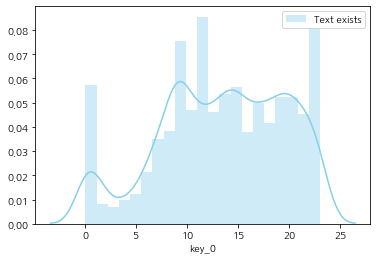

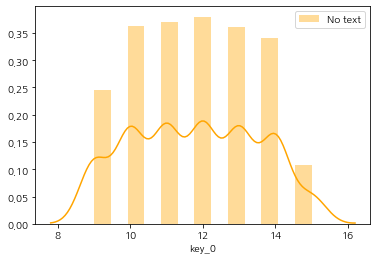

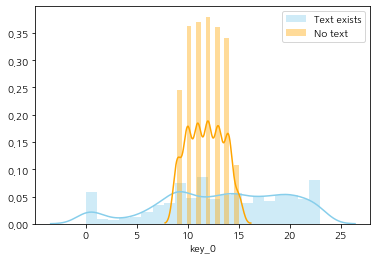

In [71]:
import seaborn as sns

sns.distplot(textnan[textnan==1].index.hour, label='Text exists', color='skyblue')
plt.legend()
plt.show()

sns.distplot(textnan[textnan==0].index.hour, label='No text', color='orange')
plt.legend()
plt.show()

sns.distplot(textnan[textnan==1].index.hour, label='Text exists', color='skyblue')
sns.distplot(textnan[textnan==0].index.hour, label='No text', color='orange')
plt.legend()
plt.show()

In [72]:
year = 2019
month = 11
day = 1
df_given_day = df[(df.index.year==year) & (df.index.month==month) & (df.index.day==day)]
df_given_day = df_given_day[df_given_day['close'].notnull()]

In [73]:
df_given_day.isna().sum()

close        0
high         0
low          0
open         0
vol          0
Views      239
Title      239
Content    239
Like       242
Unlike     242
Ip         242
dtype: int64

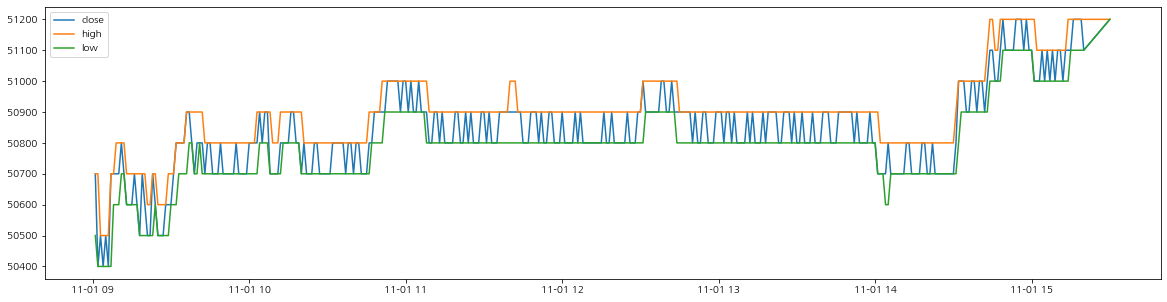

In [74]:
plt.figure(figsize=(20, 5))
plt.plot(df_given_day['close'].astype('int'), label='close')
plt.plot(df_given_day['high'].astype('int'), label='high')
plt.plot(df_given_day['low'].astype('int'), label='low')
plt.legend()
plt.show()

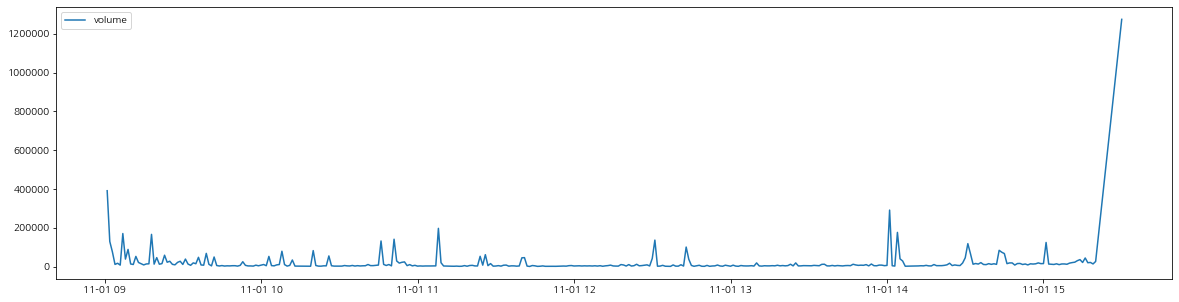

In [75]:
plt.figure(figsize=(20, 5))
plt.plot(df_given_day['vol'].astype('int'), label='volume')
plt.legend()
plt.show()

# Prepare Dataset

In [76]:
from sklearn.model_selection import train_test_split
import datetime

In [77]:
# hyperparameters
time_delay_to_predict = datetime.timedelta(minutes=5)
filename = 'data/example/preprocessed_005930.pkl'

In [78]:
# get target value
def get_target_value(filename, time_delay_to_predict) : 
    df = pd.read_pickle(filename)
    df = df.reset_index(drop=False)
    df = df[df['close'].notnull()]

    df['target'] = -1

    def get_delayed_price(idx) : 
        try : 
            current_time = df['key_0'][idx]
            delayed_time = current_time + time_delay_to_predict
            delayed_price = df[df['key_0']==delayed_time]
            df['target'].iloc[idx] = delayed_price['close'].values[0]
            pbar.update(1)
            return
        except Exception as e :
            pbar.update(1)
            return

    # create target (y) column
    with tqdm.tqdm(total=df.shape[0]) as pbar:
        for i in range(df.shape[0]) :
            get_delayed_price(i)
            
    return df

df = get_target_value(filename, time_delay_to_predict)

  0%|          | 0/3800 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████| 3800/3800 [00:13<00:00, 273.94it/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


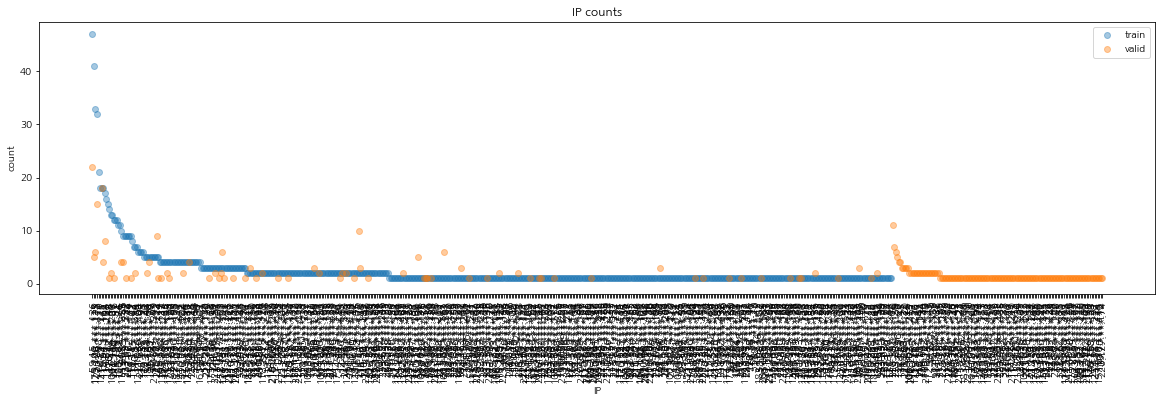

(1254, 7) 1184
(418, 7) 396


In [79]:
def split_df(df) : 

    df_notnull = df[(df['Title'].notnull()) & (df['target']!=-1)]
    df_notnull = df[df['Like'].notnull()]
    df_notnull = df[df['Unlike'].notnull()]
    df_notnull['PriceInTxt'] = df_notnull['PriceInTxt'].apply(lambda x : np.nan if x==-1 else x)
    df_train, df_valid = train_test_split(df_notnull, shuffle=False)
    
    columns_to_drop = ['Title', 'Content', 'key_0', 'high', 'low', 'target']

    train_titles = df_train['Title']
    train_contents = df_train['Content']
    train_timestamp = df_train['key_0']
    train_labels = df_train['target']
    train_numeric = df_train.drop(columns_to_drop, axis=1)

    valid_titles = df_valid['Title']
    valid_contents = df_valid['Content']
    valid_timestamp = df_valid['key_0']
    valid_labels = df_valid['target']
    valid_numeric = df_valid.drop(columns_to_drop, axis=1)
    
    # show IP count
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.scatter(train_numeric['Ip'].value_counts().index, train_numeric['Ip'].value_counts(), marker='o', alpha=0.4, label='train')
    plt.scatter(valid_numeric['Ip'].value_counts().index, valid_numeric['Ip'].value_counts(), marker='o', alpha=0.4, label='valid')
    plt.legend()
    plt.title('IP counts')
    plt.xlabel('IP')
    plt.ylabel('count')
    plt.show()
    train_numeric = train_numeric.drop(['Ip'], axis=1)
    valid_numeric = valid_numeric.drop(['Ip'], axis=1)
    
    # how many rows have price in text?
    print(train_numeric.shape, train_numeric['PriceInTxt'].isna().sum())
    print(valid_numeric.shape, valid_numeric['PriceInTxt'].isna().sum())
    train_numeric = train_numeric.drop(['PriceInTxt'], axis=1)
    valid_numeric = valid_numeric.drop(['PriceInTxt'], axis=1)
    
    # to convert as torch, change datatype
    for column in train_numeric.columns : 
        train_numeric[column] = train_numeric[column].astype(int)
        valid_numeric[column] = valid_numeric[column].astype(int)
    train_numeric = train_numeric.values
    valid_numeric = valid_numeric.values
    
    return train_titles, train_contents, train_timestamp, train_numeric, train_labels, valid_titles, valid_contents, valid_timestamp, valid_numeric, valid_labels

train_titles, train_contents, train_timestamp, train_numeric, train_labels, valid_titles, valid_contents, valid_timestamp, valid_numeric, valid_labels = split_df(df)

In [80]:
def get_tokenized(titles, contents, labels) : 
    titles_tokens = list(map(lambda t: ['[CLS]'] + sp.EncodeAsPieces(t) + ['[SEP]'], titles))
    titles_tokens_ids = pad_sequences(list(map(vocab.to_indices, titles_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
    titles_masks = [[float(i > 0) for i in ii] for ii in titles_tokens_ids]

    contents_tokens = list(map(lambda t: ['[CLS]'] + sp.EncodeAsPieces(t) + ['[SEP]'], contents))
    contents_tokens_ids = pad_sequences(list(map(vocab.to_indices, contents_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
    contents_masks = [[float(i > 0) for i in ii] for ii in contents_tokens_ids]

    y = labels.values
    
    return titles_tokens, titles_tokens_ids, titles_masks, contents_tokens, contents_tokens_ids, contents_masks, y

train_titles_tokens, train_titles_tokens_ids, train_titles_masks, train_contents_tokens, train_contents_tokens_ids, train_contents_masks, train_y = get_tokenized(train_titles, train_contents, train_labels)
valid_titles_tokens, valid_titles_tokens_ids, valid_titles_masks, valid_contents_tokens, valid_contents_tokens_ids, valid_contents_masks, valid_y = get_tokenized(valid_titles, valid_contents, valid_labels)

# Model

In [81]:
class BertRegressor(nn.Module) : 
    def __init__(self, pretrained_bert, num_numeric, size_final) : 
        super(BertRegressor, self).__init__()
        
        self.num_numeric = num_numeric
        self.size_final = size_final
        self.relu = nn.ReLU()
        
        self.bert = pretrained_bert
        
        self.fc_in = nn.Linear(self.num_numeric, self.num_numeric)
        
        self.fc_1 = nn.Linear(768+self.num_numeric, self.size_final)

        self.fc_out = nn.Linear(self.size_final, 1)
    
    def forward(self, tokens, numerics, masks=None) : 
        # 1. bert for toknes
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)  
        
        # 2. fcn for numerical input
        fc_in = self.relu(self.fc_in(numerics))       
        
        # 3. concat output : (768 + num_of_numeric) -> bottleneck size
        fc_1 = self.relu(self.fc_1(torch.cat([pooled_output, fc_in], dim=1)))
        
        # 4. final price : bottleneck -> 1
        predicted_price = self.relu(self.fc_out(fc_1))

        return predicted_price

In [82]:
# load pretrained bert
# as class itself doesn't call pretrained-bert, 
# in future it may inherit fine-tuned bert
# so step below may be skipped
pretrained_bert, vocab = get_pytorch_kobert_model() 
bottleneck_size = 300

num_of_numeric_features = train_numeric.shape[1]
bert_reg = BertRegressor(pretrained_bert, num_of_numeric_features, bottleneck_size)
bert_reg.to(device)
optimizer = torch.optim.Adam(bert_reg.parameters(), lr=3e-6)
bert_reg.train()

using cached model
using cached model


BertRegressor(
  (relu): ReLU()
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [83]:
bert_reg.eval()
x_text = torch.tensor(train_contents_tokens_ids[:3]).long().to(device)
x_numeric = torch.tensor(train_numeric[:3]).float().to(device)
y = bert_reg(x_text, x_numeric)

y_true = train_labels[:3]

In [84]:
# decoded x_text
recon = list(map(lambda t: t.cpu().numpy().tolist(), x_text))
recon = list(map(lambda t: [x for x in t if x != 0], recon))
recon = list(map(vocab.to_tokens, recon))
recon = list(map(sp.decode_pieces, recon))
recon

['[CLS] 이젠 호모쉐퀴들도 부역자 노릇을 하는구나 군대도 안다녀온 게이새끼 허위사실유포로 감옥에 쳐넣어라. 아 감옥에는 호모새끼들이 은근히 많아서 벌이 아니라 상일려나? 군인권센터 저사람부터가 친민주당계열사람이자나  문제는 주사파 빨갱이척결이 먼저다~~! pakh**** 저 게이새끼부터 군대 잡아쳐넣어라. 군대도 안갔다온 놈이 군인권세터..? 삶은 소대가리도 웃는다. 계엄문건..? GR염병들하고 있네. 모든 작전문서는 2년마다 상횡이 바에 따라 엎데이트를 한다. 실무자가 엎데이트 초안을 작성한거가지고 내란음모라고 떠드는 군대도 안갔다온 새끼를 잡아쳐넣어야 한다.제발 무식하면 전문가에게 물어봐라. 6027작계 개편하면 전쟁선동 준비하는거냐? 문재앙아 대답좀 해봐라. 어디가서 특전사 나왔다고 해척조훈련(스쿠바훈련) 받았다고 뻥치지마라. 이 형님같은 특전사출신들이 개웃는다.[SEP]',
 '[CLS] 자료는 공개되었네요못보신 분들은 확인하세요 링크 컨콜은 아래에서 신청 후 참여 가능합니다 링크[SEP]',
 '[CLS] ᄏᄏ[SEP]']

In [85]:
# numeric values
np.set_printoptions(suppress=True) 
print(x_numeric.cpu().numpy())

[[ 50900.  51000. 580976.    192.      6.      4.]
 [ 50900.  51000. 580976.    544.      0.      0.]
 [ 51100.  51100.  13198.    135.      0.      0.]]


In [86]:
# predicted value
y

tensor([[  0.0000],
        [  0.0000],
        [157.0676]], device='cuda:0', grad_fn=<ReluBackward0>)

In [87]:
# target value (real one)
y_true

0    51000
1    51000
3    51200
Name: target, dtype: int64

# Training